In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import numpy as np
import os
import json

from datetime import datetime
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

from utils import load_fold_paths, compute_metrics, cleanup, print_metrics, plot_confusion_matrix, print_cross_validation_results
from models.helper_classes import TrainingHistory
from models.cnn import AudioCNN, LazyAudioCNNDataset, collate_fn_cnn

In [3]:
METADATA_PATH = '../UrbanSound8K/metadata/UrbanSound8K.csv'
AUDIO_BASE_PATH = '../UrbanSound8K/audio'

In [4]:
def train_audio_cnn_cross_validation(data_cache_dir, config):
    """
        10-Fold Cross-Validation Pipeline for UrbanSound8K
        """
    epochs = config["epochs"]
    batch_size = config["batch_size"]
    lr = config["lr"]
    num_classes = config["num_classes"]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"Initial GPU memory allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
    
    train_paths, train_labels, test_paths, test_labels = load_fold_paths(data_cache_dir=data_cache_dir)
    
    timestamp = datetime.now().strftime("%m%d_%H%M%S")
    save_dir = f"../saved_cv/{timestamp}"
    os.makedirs(save_dir, exist_ok=True)
    print(f"Save directory: {save_dir}")
    
    with open(os.path.join(save_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=2)
    
    fold_results = []
    all_fold_accuracies = []
    cumulative_confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    print("\n" + "="*60)
    print("10-FOLD CROSS-VALIDATION")
    print("="*60)
    print("Scheme: 1 fold test, 1 fold validation, 8 folds training")
    print("="*60)
    
    for test_fold in range(1, 11):
        val_fold = (test_fold % 10) + 1
        train_folds = [f for f in range(1, 11) if f != test_fold and f != val_fold]
        
        print(f"\n{'='*60}")
        print(f"FOLD {test_fold}/10")
        print(f"{'='*60}")
        print(f"Test fold: {test_fold}")
        print(f"Validation fold: {val_fold}")
        print(f"Training folds: {train_folds}")
        
        fold_dir = os.path.join(save_dir, f'fold_{test_fold}')
        os.makedirs(fold_dir, exist_ok=True)
        
        print("\n" + "="*60)
        print("STEP 1: Loading Data from Cache")
        print("="*60)

        X_train = sum((train_paths[f] for f in train_folds), [])
        y_train = sum((train_labels[f] for f in train_folds), [])

        X_val = test_paths[val_fold]
        y_val = test_labels[val_fold]

        X_test = test_paths[test_fold]
        y_test = test_labels[test_fold]

        train_dataset = LazyAudioCNNDataset(X_train, y_train)
        val_dataset   = LazyAudioCNNDataset(X_val, y_val)
        test_dataset  = LazyAudioCNNDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn_cnn)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn_cnn)
        test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn_cnn)
        
        print("\n" + "="*60)
        print("STEP 2: Creating Model")
        print("="*60)
        
        model = AudioCNN(num_classes=num_classes, config=config)
        model = model.to(device)
        
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total parameters: {total_params:,}")
        
        if torch.cuda.is_available():
            print(f"GPU memory after model creation: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
        
        print("\n" + "="*60)
        print("STEP 3: Training Model")
        print("="*60)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                                    betas = (config.get('betas')[0],
                                    config.get('betas')[1]),
                                    eps = config.get('eps'),
                                    weight_decay=config.get('weight_decay'))
        history = TrainingHistory()
        
        best_val_loss, best_val_acc = AudioCNN.trainModel(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            test_fold=test_fold,
            history=history,
            config=config,
            fold_dir=fold_dir,
            epochs=epochs,
            optimizer=optimizer,
            criterion=criterion,
            device=device
        )

        print("\n" + "="*60)
        print("STEP 4: Testing on Held-Out Fold")
        print("="*60)
        
        checkpoint = torch.load(os.path.join(fold_dir, 'best_model.pth'))
        model.load_state_dict(checkpoint['model_state_dict'])
        
        model.eval()

        avg_test_loss, test_acc, all_predictions, all_targets = AudioCNN.test(model, criterion, test_loader, device)
        
        print(f"\nTest Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        
        test_metrics = compute_metrics(all_predictions, all_targets, num_classes)
        print_metrics(test_metrics, prefix="Test ")
        
        fold_confusion_matrix = confusion_matrix(all_targets, all_predictions, labels=range(num_classes))
        cumulative_confusion_matrix += fold_confusion_matrix
        
        fold_result = {
            'fold': test_fold,
            'test_fold': test_fold,
            'val_fold': val_fold,
            'train_folds': train_folds,
            'test_loss': avg_test_loss,
            'test_accuracy': test_metrics['accuracy'],
            'test_precision_macro': test_metrics['precision_macro'],
            'test_precision_weighted': test_metrics['precision_weighted'],
            'test_recall_macro': test_metrics['recall_macro'],
            'test_recall_weighted': test_metrics['recall_weighted'],
            'test_f1_macro': test_metrics['f1_macro'],
            'test_f1_weighted': test_metrics['f1_weighted'],
            'test_precision_per_class': test_metrics['precision_per_class'],
            'test_recall_per_class': test_metrics['recall_per_class'],
            'test_f1_per_class': test_metrics['f1_per_class'],
            'best_val_accuracy': best_val_acc,
            'best_val_loss': best_val_loss,
            'confusion_matrix': fold_confusion_matrix.tolist()
        }
        fold_results.append(fold_result)
        all_fold_accuracies.append(test_acc)
        
        with open(os.path.join(fold_dir, 'fold_results.json'), 'w') as f:
            json.dump(fold_result, f, indent=2)
        
        class_names = [f'Class_{i}' for i in range(num_classes)]
        report = classification_report(all_targets, all_predictions, 
                                      target_names=class_names, 
                                      digits=4)
        with open(os.path.join(fold_dir, 'classification_report.txt'), 'w') as f:
            f.write(f"Classification Report - Fold {test_fold}\n")
            f.write("="*60 + "\n")
            f.write(report)
        
        history.save(os.path.join(fold_dir, 'history.json'))
        history.plot(save_path=os.path.join(fold_dir, 'training_curves.png'))
        
        plot_confusion_matrix(
            fold_confusion_matrix,
            save_path=os.path.join(fold_dir, 'confusion_matrix.png'),
            title=f'Confusion Matrix - Fold {test_fold}'
        )
        
        print(f"\nFold {test_fold} completed!")
        print(f"Results saved to: {fold_dir}")
        
        cleanup(train_loader, val_loader, test_loader,
            train_dataset, val_dataset, test_dataset,
            model, optimizer, criterion, history,
            all_predictions, all_targets,
            checkpoint)

    print("\n" + "="*60)
    print("CROSS-VALIDATION RESULTS")
    print("="*60)

    return print_cross_validation_results(fold_results, save_dir, cumulative_confusion_matrix, all_fold_accuracies, config)

In [5]:
import os
from datetime import datetime

from utils import read_config

config = read_config("../config/cnn.json")

base_dir = '../data_cache'
folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

folder_dates = []
for folder in folders:
    try:
        folder_date = datetime.strptime(folder, '%m%d_%H%M%S')
        folder_dates.append((folder_date, folder))
    except ValueError:
        print(f"Folder name '{folder}' does not match expected format.")

if folder_dates:
    most_recent_folder = max(folder_dates, key=lambda x: x[0])[1]
    data_cache_dir = os.path.join(base_dir, most_recent_folder)
    print(f"Most recent folder: {data_cache_dir}")

else:
    print("No valid folders found.")

Most recent folder: ../data_cache/1128_230416


Using device: cuda
Initial GPU memory allocated: 0.00 MB
Save directory: ../saved_cv/1130_014235

10-FOLD CROSS-VALIDATION
Scheme: 1 fold test, 1 fold validation, 8 folds training

FOLD 1/10
Test fold: 1
Validation fold: 2
Training folds: [3, 4, 5, 6, 7, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 29,706
GPU memory after model creation: 0.65 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.7355, Train Acc: 0.3487
Val Loss: 1.8586, Val Acc: 0.2905
✓ Best model saved (Val Loss: 1.8586)

Epoch 2/20
----------------------------------------


Train Loss: 1.4268, Train Acc: 0.4643
Val Loss: 1.7951, Val Acc: 0.3604
✓ Best model saved (Val Loss: 1.7951)

Epoch 3/20
----------------------------------------


Train Loss: 1.2803, Train Acc: 0.5396
Val Loss: 1.9503, Val Acc: 0.3423

Epoch 4/20
----------------------------------------


Train Loss: 1.1773, Train Acc: 0.5768
Val Loss: 1.6081, Val Acc: 0.4313
✓ Best model saved (Val Loss: 1.6081)

Epoch 5/20
----------------------------------------


Train Loss: 1.0994, Train Acc: 0.6131
Val Loss: 2.1023, Val Acc: 0.3502

Epoch 6/20
----------------------------------------


Train Loss: 0.9430, Train Acc: 0.6725
Val Loss: 2.0600, Val Acc: 0.4178

Epoch 7/20
----------------------------------------


Train Loss: 0.9287, Train Acc: 0.6867
Val Loss: 1.3689, Val Acc: 0.5890
✓ Best model saved (Val Loss: 1.3689)

Epoch 8/20
----------------------------------------


Train Loss: 0.8582, Train Acc: 0.7119
Val Loss: 1.5628, Val Acc: 0.4865

Epoch 9/20
----------------------------------------


Train Loss: 0.8352, Train Acc: 0.7215
Val Loss: 1.3796, Val Acc: 0.5608

Epoch 10/20
----------------------------------------


Train Loss: 0.8246, Train Acc: 0.7252
Val Loss: 1.3591, Val Acc: 0.5777
✓ Best model saved (Val Loss: 1.3591)

Epoch 11/20
----------------------------------------


Train Loss: 0.7406, Train Acc: 0.7561
Val Loss: 1.5138, Val Acc: 0.5867

Epoch 12/20
----------------------------------------


Train Loss: 0.7078, Train Acc: 0.7616
Val Loss: 1.3381, Val Acc: 0.6250
✓ Best model saved (Val Loss: 1.3381)

Epoch 13/20
----------------------------------------


Train Loss: 0.6697, Train Acc: 0.7775
Val Loss: 1.3469, Val Acc: 0.6182

Epoch 14/20
----------------------------------------


Train Loss: 0.6642, Train Acc: 0.7811
Val Loss: 1.4629, Val Acc: 0.6149

Epoch 15/20
----------------------------------------


Train Loss: 0.6560, Train Acc: 0.7797
Val Loss: 1.1861, Val Acc: 0.6633
✓ Best model saved (Val Loss: 1.1861)

Epoch 16/20
----------------------------------------


Train Loss: 0.5879, Train Acc: 0.8041
Val Loss: 1.8734, Val Acc: 0.6216

Epoch 17/20
----------------------------------------


Train Loss: 0.5740, Train Acc: 0.8137
Val Loss: 1.3360, Val Acc: 0.6273

Epoch 18/20
----------------------------------------


Train Loss: 0.5636, Train Acc: 0.8166
Val Loss: 1.2184, Val Acc: 0.6633

Epoch 19/20
----------------------------------------


Train Loss: 0.5567, Train Acc: 0.8210
Val Loss: 1.3037, Val Acc: 0.6847

Epoch 20/20
----------------------------------------


Train Loss: 0.5454, Train Acc: 0.8217
Val Loss: 1.5713, Val Acc: 0.6408

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 28/28 [00:00<00:00, 47.29it/s, loss=0.7492]



Test Loss: 1.2313
Test Accuracy: 0.6460

Test Metrics:
  Accuracy:          0.6460
  Precision (macro): 0.6345
  Recall (macro):    0.6743
  F1-Score (macro):  0.6398
  Precision (wtd):   0.6445
  Recall (wtd):      0.6460
  F1-Score (wtd):    0.6333


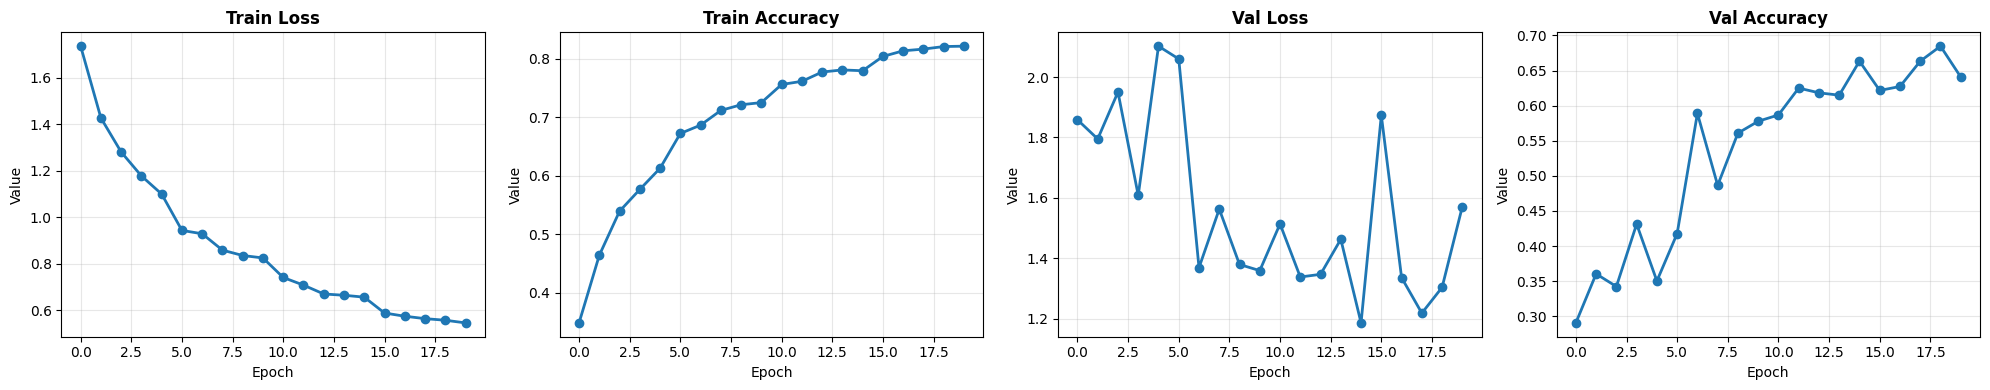

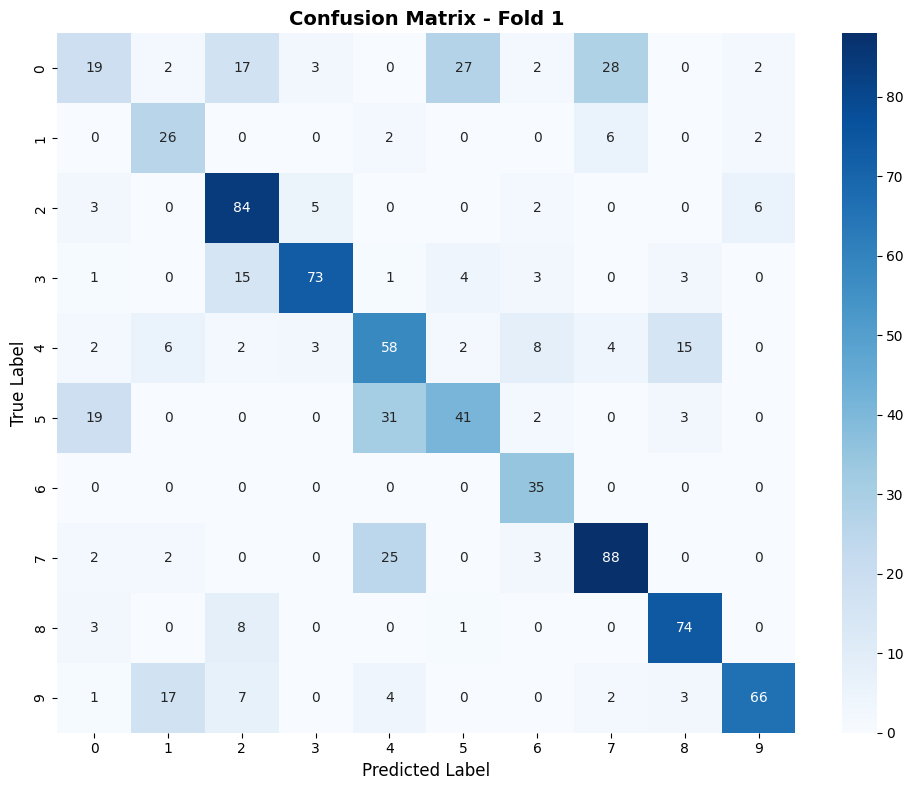


Fold 1 completed!
Results saved to: ../saved_cv/1130_014235/fold_1

FOLD 2/10
Test fold: 2
Validation fold: 3
Training folds: [1, 4, 5, 6, 7, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 29,706
GPU memory after model creation: 18.26 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.7101, Train Acc: 0.3627
Val Loss: 1.7422, Val Acc: 0.3578
✓ Best model saved (Val Loss: 1.7422)

Epoch 2/20
----------------------------------------


Train Loss: 1.4131, Train Acc: 0.4871
Val Loss: 1.6203, Val Acc: 0.4184
✓ Best model saved (Val Loss: 1.6203)

Epoch 3/20
----------------------------------------


Train Loss: 1.2671, Train Acc: 0.5508
Val Loss: 1.5335, Val Acc: 0.4184
✓ Best model saved (Val Loss: 1.5335)

Epoch 4/20
----------------------------------------


Train Loss: 1.1590, Train Acc: 0.5990
Val Loss: 1.7978, Val Acc: 0.4054

Epoch 5/20
----------------------------------------


Train Loss: 1.0620, Train Acc: 0.6198
Val Loss: 2.2037, Val Acc: 0.3427

Epoch 6/20
----------------------------------------


Train Loss: 0.9183, Train Acc: 0.6885
Val Loss: 1.3243, Val Acc: 0.5708
✓ Best model saved (Val Loss: 1.3243)

Epoch 7/20
----------------------------------------


Train Loss: 0.8714, Train Acc: 0.7026
Val Loss: 2.2750, Val Acc: 0.4043

Epoch 8/20
----------------------------------------


Train Loss: 0.8184, Train Acc: 0.7232
Val Loss: 1.4583, Val Acc: 0.5438

Epoch 9/20
----------------------------------------


Train Loss: 0.7901, Train Acc: 0.7330
Val Loss: 2.0450, Val Acc: 0.4984

Epoch 10/20
----------------------------------------


Train Loss: 0.7705, Train Acc: 0.7439
Val Loss: 1.4956, Val Acc: 0.5286

Epoch 11/20
----------------------------------------


Train Loss: 0.6636, Train Acc: 0.7799
Val Loss: 1.3725, Val Acc: 0.5568

Epoch 12/20
----------------------------------------


Train Loss: 0.6385, Train Acc: 0.7884
Val Loss: 1.5636, Val Acc: 0.5816

Epoch 13/20
----------------------------------------


Train Loss: 0.6237, Train Acc: 0.7968
Val Loss: 1.2414, Val Acc: 0.6486
✓ Best model saved (Val Loss: 1.2414)

Epoch 14/20
----------------------------------------


Train Loss: 0.5945, Train Acc: 0.8003
Val Loss: 1.5281, Val Acc: 0.5978

Epoch 15/20
----------------------------------------


Train Loss: 0.5949, Train Acc: 0.8051
Val Loss: 1.3034, Val Acc: 0.6086

Epoch 16/20
----------------------------------------


Train Loss: 0.5277, Train Acc: 0.8267
Val Loss: 1.3953, Val Acc: 0.6108

Epoch 17/20
----------------------------------------


Train Loss: 0.5229, Train Acc: 0.8272
Val Loss: 1.4743, Val Acc: 0.5978

Epoch 18/20
----------------------------------------


Train Loss: 0.5045, Train Acc: 0.8330
Val Loss: 1.7058, Val Acc: 0.6011

Epoch 19/20
----------------------------------------


Train Loss: 0.5008, Train Acc: 0.8355
Val Loss: 1.4773, Val Acc: 0.5978

Epoch 20/20
----------------------------------------


Train Loss: 0.4753, Train Acc: 0.8403
Val Loss: 1.8076, Val Acc: 0.5762

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 28/28 [00:00<00:00, 62.46it/s, loss=0.4071]



Test Loss: 1.1323
Test Accuracy: 0.6520

Test Metrics:
  Accuracy:          0.6520
  Precision (macro): 0.7162
  Recall (macro):    0.6766
  F1-Score (macro):  0.6797
  Precision (wtd):   0.6955
  Recall (wtd):      0.6520
  F1-Score (wtd):    0.6551


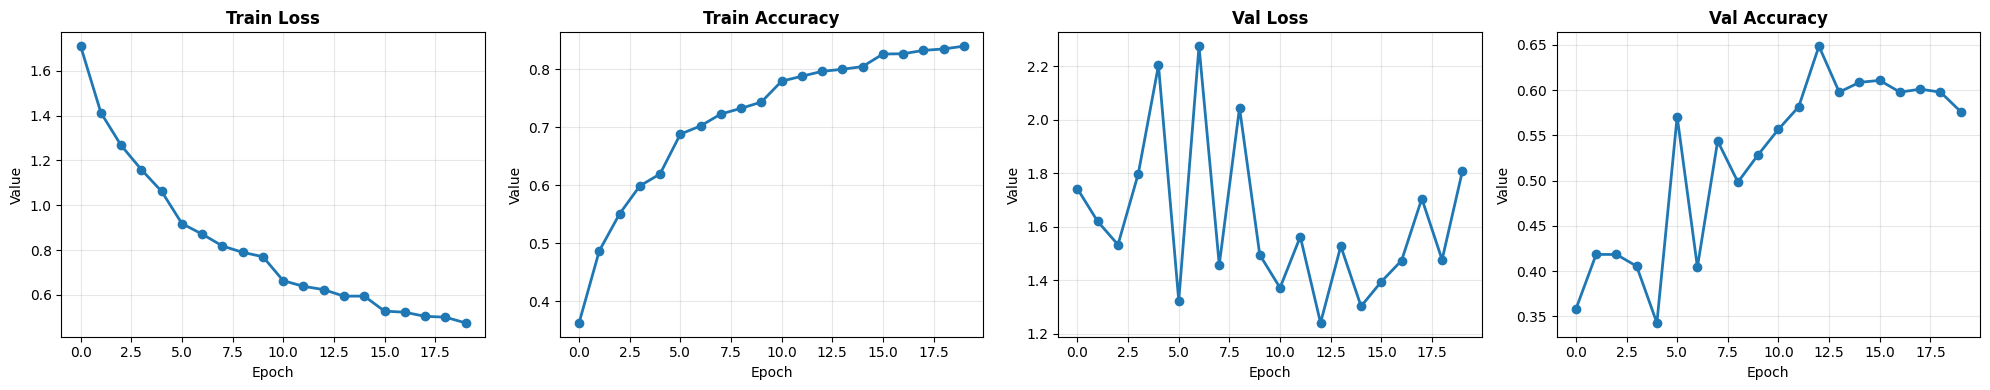

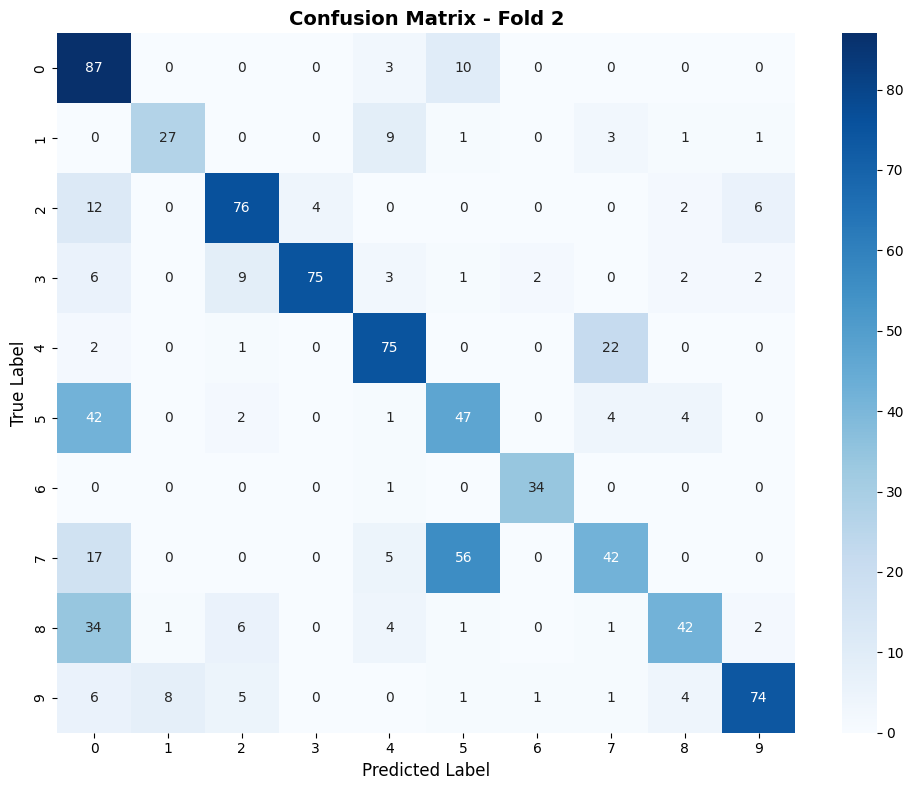


Fold 2 completed!
Results saved to: ../saved_cv/1130_014235/fold_2

FOLD 3/10
Test fold: 3
Validation fold: 4
Training folds: [1, 2, 5, 6, 7, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 29,706
GPU memory after model creation: 18.26 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.7057, Train Acc: 0.3692
Val Loss: 2.1738, Val Acc: 0.2808
✓ Best model saved (Val Loss: 2.1738)

Epoch 2/20
----------------------------------------


Train Loss: 1.4038, Train Acc: 0.4790
Val Loss: 3.9087, Val Acc: 0.1677

Epoch 3/20
----------------------------------------


Train Loss: 1.2566, Train Acc: 0.5328
Val Loss: 1.8085, Val Acc: 0.3646
✓ Best model saved (Val Loss: 1.8085)

Epoch 4/20
----------------------------------------


Train Loss: 1.1480, Train Acc: 0.5869
Val Loss: 1.8094, Val Acc: 0.4162

Epoch 5/20
----------------------------------------


Train Loss: 1.0984, Train Acc: 0.6118
Val Loss: 2.3903, Val Acc: 0.3323

Epoch 6/20
----------------------------------------


Train Loss: 0.9205, Train Acc: 0.6820
Val Loss: 1.2785, Val Acc: 0.5535
✓ Best model saved (Val Loss: 1.2785)

Epoch 7/20
----------------------------------------


Train Loss: 0.8569, Train Acc: 0.7125
Val Loss: 1.5931, Val Acc: 0.5121

Epoch 8/20
----------------------------------------


Train Loss: 0.8201, Train Acc: 0.7231
Val Loss: 1.6994, Val Acc: 0.4919

Epoch 9/20
----------------------------------------


Train Loss: 0.8028, Train Acc: 0.7293
Val Loss: 1.3729, Val Acc: 0.5970

Epoch 10/20
----------------------------------------


Train Loss: 0.7446, Train Acc: 0.7572
Val Loss: 1.4034, Val Acc: 0.5707

Epoch 11/20
----------------------------------------


Train Loss: 0.6514, Train Acc: 0.7860
Val Loss: 1.4354, Val Acc: 0.5596

Epoch 12/20
----------------------------------------


Train Loss: 0.6230, Train Acc: 0.7916
Val Loss: 1.4820, Val Acc: 0.6182

Epoch 13/20
----------------------------------------


Train Loss: 0.5847, Train Acc: 0.8085
Val Loss: 1.6615, Val Acc: 0.5960

Epoch 14/20
----------------------------------------


Train Loss: 0.5875, Train Acc: 0.8065
Val Loss: 1.8370, Val Acc: 0.5960

Epoch 15/20
----------------------------------------


Train Loss: 0.5758, Train Acc: 0.8119
Val Loss: 1.6069, Val Acc: 0.6354

Epoch 16/20
----------------------------------------


Train Loss: 0.5135, Train Acc: 0.8333
Val Loss: 2.3499, Val Acc: 0.5606

Epoch 17/20
----------------------------------------


Train Loss: 0.4882, Train Acc: 0.8351
Val Loss: 1.3623, Val Acc: 0.6505

Epoch 18/20
----------------------------------------


Train Loss: 0.4806, Train Acc: 0.8417
Val Loss: 1.8097, Val Acc: 0.6000

Epoch 19/20
----------------------------------------


Train Loss: 0.4779, Train Acc: 0.8440
Val Loss: 1.6615, Val Acc: 0.6172

Epoch 20/20
----------------------------------------


Train Loss: 0.4535, Train Acc: 0.8502
Val Loss: 1.5015, Val Acc: 0.6475

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 29/29 [00:00<00:00, 56.77it/s, loss=1.8102]



Test Loss: 1.3266
Test Accuracy: 0.5535

Test Metrics:
  Accuracy:          0.5535
  Precision (macro): 0.5971
  Recall (macro):    0.6066
  F1-Score (macro):  0.5863
  Precision (wtd):   0.5929
  Recall (wtd):      0.5535
  F1-Score (wtd):    0.5608


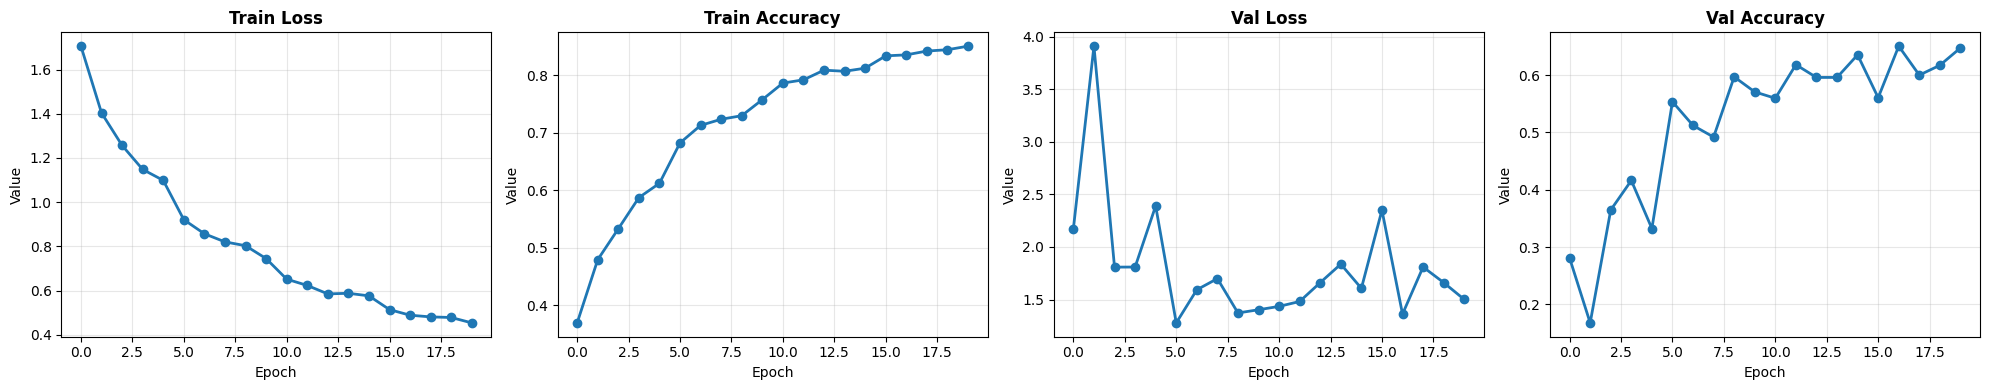

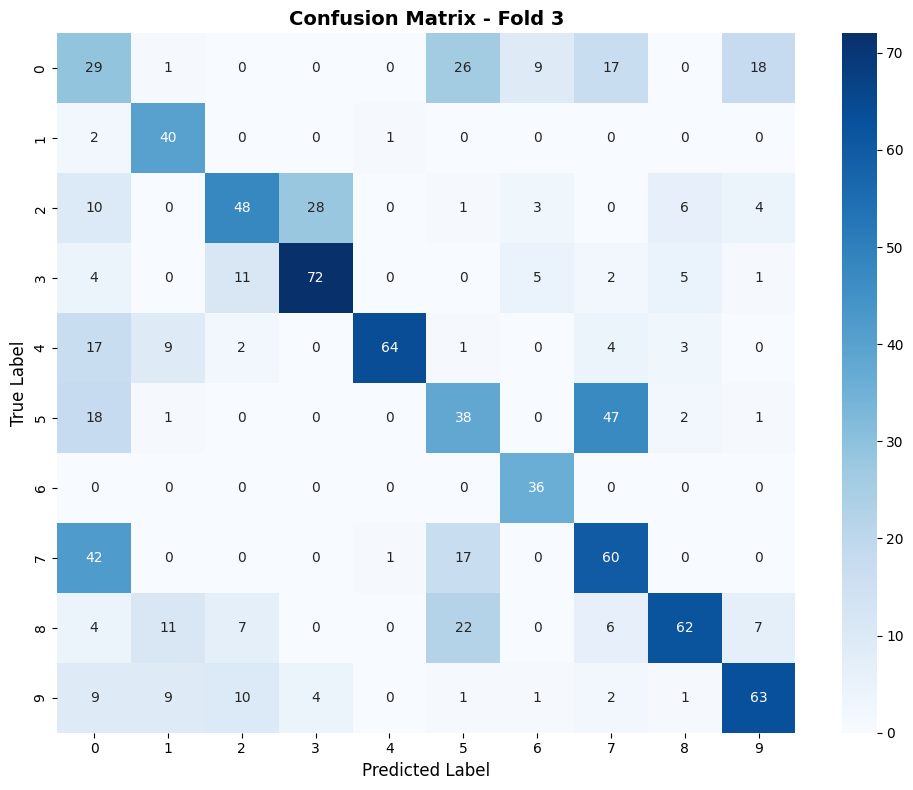


Fold 3 completed!
Results saved to: ../saved_cv/1130_014235/fold_3

FOLD 4/10
Test fold: 4
Validation fold: 5
Training folds: [1, 2, 3, 6, 7, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 29,706
GPU memory after model creation: 18.26 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.7353, Train Acc: 0.3521
Val Loss: 1.7646, Val Acc: 0.4530
✓ Best model saved (Val Loss: 1.7646)

Epoch 2/20
----------------------------------------


Train Loss: 1.5006, Train Acc: 0.4378
Val Loss: 1.7225, Val Acc: 0.4177
✓ Best model saved (Val Loss: 1.7225)

Epoch 3/20
----------------------------------------


Train Loss: 1.3650, Train Acc: 0.4968
Val Loss: 1.4635, Val Acc: 0.4284
✓ Best model saved (Val Loss: 1.4635)

Epoch 4/20
----------------------------------------


Train Loss: 1.2518, Train Acc: 0.5471
Val Loss: 2.1579, Val Acc: 0.2863

Epoch 5/20
----------------------------------------


Train Loss: 1.1672, Train Acc: 0.5810
Val Loss: 1.9508, Val Acc: 0.4444

Epoch 6/20
----------------------------------------


Train Loss: 1.0246, Train Acc: 0.6430
Val Loss: 1.6789, Val Acc: 0.4145

Epoch 7/20
----------------------------------------


Train Loss: 0.9419, Train Acc: 0.6769
Val Loss: 1.9282, Val Acc: 0.4541

Epoch 8/20
----------------------------------------


Train Loss: 0.9198, Train Acc: 0.6887
Val Loss: 1.0560, Val Acc: 0.6517
✓ Best model saved (Val Loss: 1.0560)

Epoch 9/20
----------------------------------------


Train Loss: 0.8914, Train Acc: 0.6936
Val Loss: 0.9059, Val Acc: 0.7244
✓ Best model saved (Val Loss: 0.9059)

Epoch 10/20
----------------------------------------


Train Loss: 0.8465, Train Acc: 0.7103
Val Loss: 1.0258, Val Acc: 0.6763

Epoch 11/20
----------------------------------------


Train Loss: 0.7629, Train Acc: 0.7456
Val Loss: 1.2772, Val Acc: 0.5812

Epoch 12/20
----------------------------------------


Train Loss: 0.7255, Train Acc: 0.7561
Val Loss: 0.8623, Val Acc: 0.7115
✓ Best model saved (Val Loss: 0.8623)

Epoch 13/20
----------------------------------------


Train Loss: 0.7039, Train Acc: 0.7660
Val Loss: 0.9540, Val Acc: 0.6816

Epoch 14/20
----------------------------------------


Train Loss: 0.6825, Train Acc: 0.7723
Val Loss: 1.0156, Val Acc: 0.6068

Epoch 15/20
----------------------------------------


Train Loss: 0.6681, Train Acc: 0.7789
Val Loss: 0.9479, Val Acc: 0.7009

Epoch 16/20
----------------------------------------


Train Loss: 0.6127, Train Acc: 0.7992
Val Loss: 1.1036, Val Acc: 0.6528

Epoch 17/20
----------------------------------------


Train Loss: 0.5920, Train Acc: 0.8040
Val Loss: 0.9313, Val Acc: 0.6784

Epoch 18/20
----------------------------------------


Train Loss: 0.5843, Train Acc: 0.8077
Val Loss: 0.7720, Val Acc: 0.7724
✓ Best model saved (Val Loss: 0.7720)

Epoch 19/20
----------------------------------------


Train Loss: 0.5670, Train Acc: 0.8159
Val Loss: 0.7811, Val Acc: 0.7468

Epoch 20/20
----------------------------------------


Train Loss: 0.5478, Train Acc: 0.8229
Val Loss: 0.8578, Val Acc: 0.7318

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 31/31 [00:00<00:00, 57.86it/s, loss=0.6469]



Test Loss: 1.3546
Test Accuracy: 0.6758

Test Metrics:
  Accuracy:          0.6758
  Precision (macro): 0.6929
  Recall (macro):    0.6743
  F1-Score (macro):  0.6791
  Precision (wtd):   0.6882
  Recall (wtd):      0.6758
  F1-Score (wtd):    0.6781


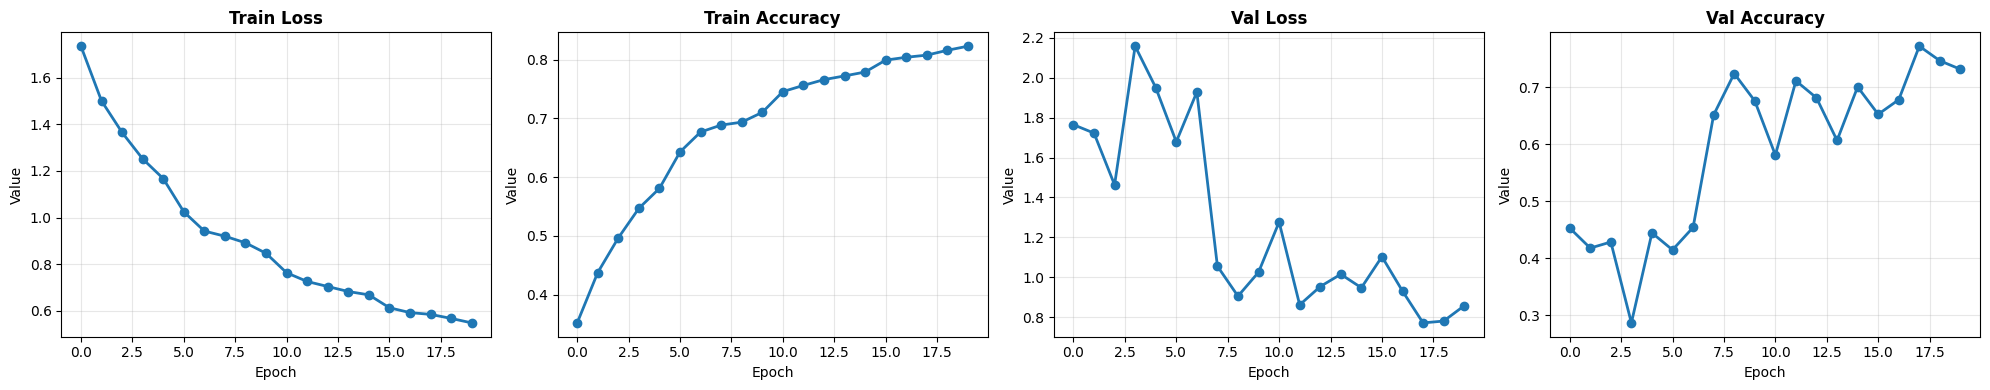

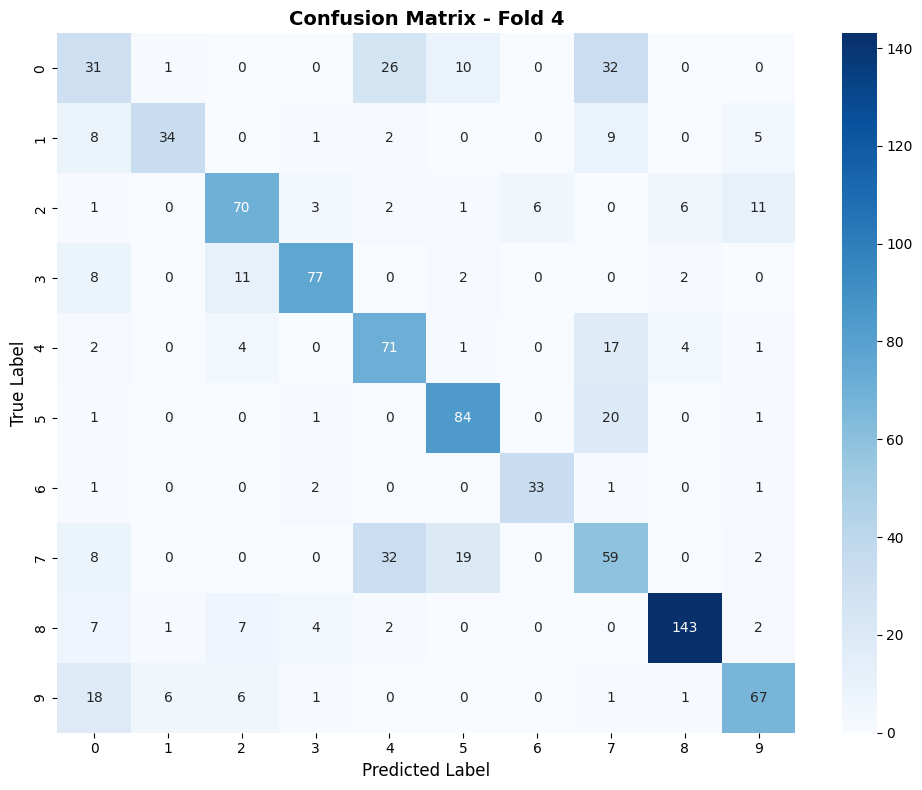


Fold 4 completed!
Results saved to: ../saved_cv/1130_014235/fold_4

FOLD 5/10
Test fold: 5
Validation fold: 6
Training folds: [1, 2, 3, 4, 7, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 29,706
GPU memory after model creation: 18.26 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.7002, Train Acc: 0.3667
Val Loss: 2.1319, Val Acc: 0.2552
✓ Best model saved (Val Loss: 2.1319)

Epoch 2/20
----------------------------------------


Train Loss: 1.4334, Train Acc: 0.4560
Val Loss: 2.3705, Val Acc: 0.2357

Epoch 3/20
----------------------------------------


Train Loss: 1.3033, Train Acc: 0.5212
Val Loss: 1.7660, Val Acc: 0.4411
✓ Best model saved (Val Loss: 1.7660)

Epoch 4/20
----------------------------------------


Train Loss: 1.2040, Train Acc: 0.5756
Val Loss: 1.5429, Val Acc: 0.4593
✓ Best model saved (Val Loss: 1.5429)

Epoch 5/20
----------------------------------------


Train Loss: 1.1184, Train Acc: 0.6103
Val Loss: 1.7229, Val Acc: 0.4326

Epoch 6/20
----------------------------------------


Train Loss: 0.9685, Train Acc: 0.6697
Val Loss: 1.8350, Val Acc: 0.4751

Epoch 7/20
----------------------------------------


Train Loss: 0.8941, Train Acc: 0.6971
Val Loss: 1.4569, Val Acc: 0.5711
✓ Best model saved (Val Loss: 1.4569)

Epoch 8/20
----------------------------------------


Train Loss: 0.8586, Train Acc: 0.7132
Val Loss: 1.6773, Val Acc: 0.5747

Epoch 9/20
----------------------------------------


Train Loss: 0.8335, Train Acc: 0.7224
Val Loss: 1.7456, Val Acc: 0.4544

Epoch 10/20
----------------------------------------


Train Loss: 0.8026, Train Acc: 0.7356
Val Loss: 1.8995, Val Acc: 0.4727

Epoch 11/20
----------------------------------------


Train Loss: 0.7066, Train Acc: 0.7660
Val Loss: 1.3360, Val Acc: 0.5808
✓ Best model saved (Val Loss: 1.3360)

Epoch 12/20
----------------------------------------


Train Loss: 0.6810, Train Acc: 0.7693
Val Loss: 1.2647, Val Acc: 0.6015
✓ Best model saved (Val Loss: 1.2647)

Epoch 13/20
----------------------------------------


Train Loss: 0.6518, Train Acc: 0.7825
Val Loss: 3.4482, Val Acc: 0.3220

Epoch 14/20
----------------------------------------


Train Loss: 0.6490, Train Acc: 0.7770
Val Loss: 1.2957, Val Acc: 0.6002

Epoch 15/20
----------------------------------------


Train Loss: 0.5974, Train Acc: 0.8048
Val Loss: 1.2562, Val Acc: 0.6027
✓ Best model saved (Val Loss: 1.2562)

Epoch 16/20
----------------------------------------


Train Loss: 0.5520, Train Acc: 0.8123
Val Loss: 1.3079, Val Acc: 0.6173

Epoch 17/20
----------------------------------------


Train Loss: 0.5400, Train Acc: 0.8174
Val Loss: 1.2499, Val Acc: 0.6197
✓ Best model saved (Val Loss: 1.2499)

Epoch 18/20
----------------------------------------


Train Loss: 0.5440, Train Acc: 0.8197
Val Loss: 1.2959, Val Acc: 0.6112

Epoch 19/20
----------------------------------------


Train Loss: 0.5096, Train Acc: 0.8295
Val Loss: 1.4356, Val Acc: 0.5954

Epoch 20/20
----------------------------------------


Train Loss: 0.5127, Train Acc: 0.8262
Val Loss: 1.3277, Val Acc: 0.6160

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 30/30 [00:00<00:00, 57.96it/s, loss=0.2139]



Test Loss: 0.6944
Test Accuracy: 0.7682

Test Metrics:
  Accuracy:          0.7682
  Precision (macro): 0.7905
  Recall (macro):    0.7784
  F1-Score (macro):  0.7773
  Precision (wtd):   0.7766
  Recall (wtd):      0.7682
  F1-Score (wtd):    0.7646


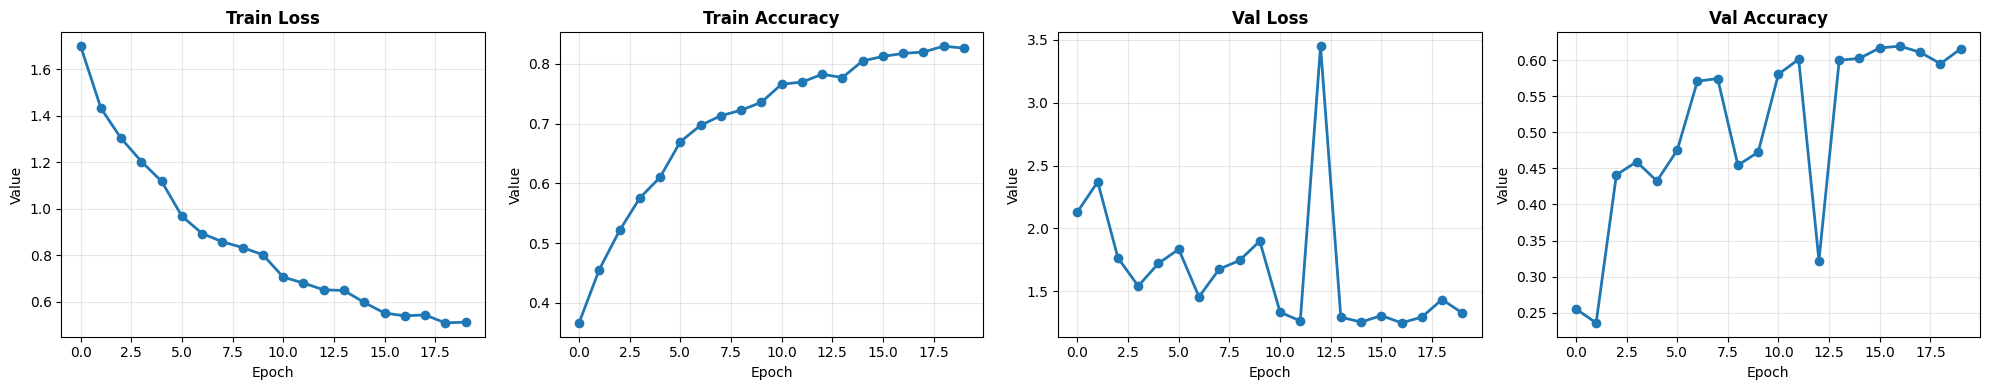

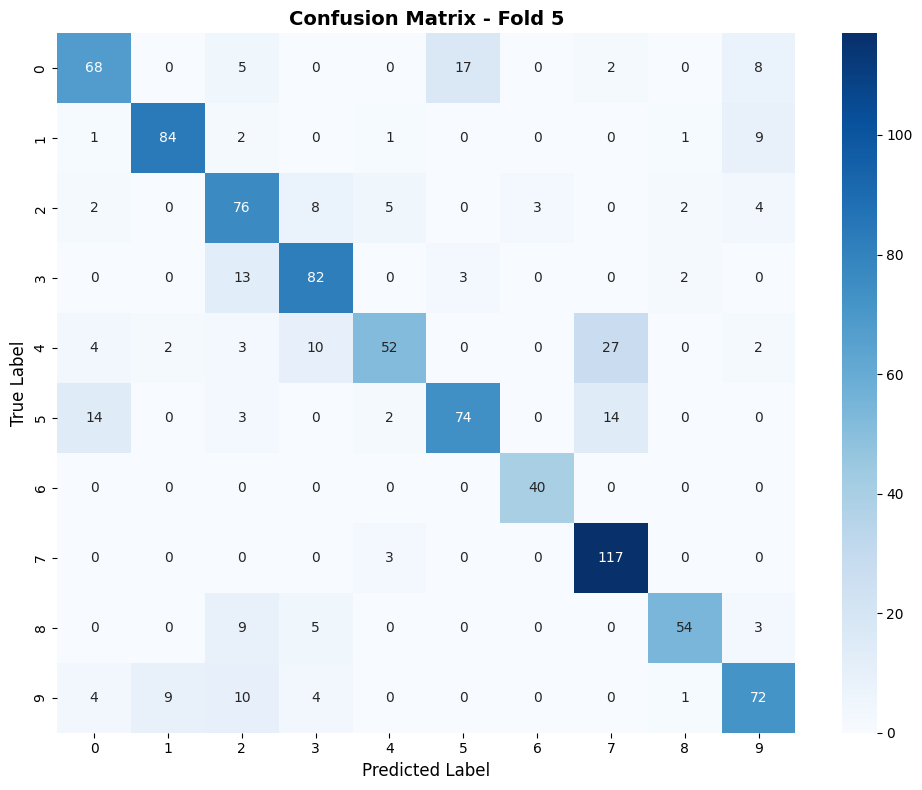


Fold 5 completed!
Results saved to: ../saved_cv/1130_014235/fold_5

FOLD 6/10
Test fold: 6
Validation fold: 7
Training folds: [1, 2, 3, 4, 5, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 29,706
GPU memory after model creation: 18.26 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.7164, Train Acc: 0.3618
Val Loss: 1.4302, Val Acc: 0.4033
✓ Best model saved (Val Loss: 1.4302)

Epoch 2/20
----------------------------------------


Train Loss: 1.4500, Train Acc: 0.4610
Val Loss: 1.5050, Val Acc: 0.4487

Epoch 3/20
----------------------------------------


Train Loss: 1.2981, Train Acc: 0.5203
Val Loss: 1.4561, Val Acc: 0.4332

Epoch 4/20
----------------------------------------


Train Loss: 1.1734, Train Acc: 0.5803
Val Loss: 1.9402, Val Acc: 0.3878

Epoch 5/20
----------------------------------------


Train Loss: 1.0680, Train Acc: 0.6180
Val Loss: 3.4844, Val Acc: 0.2995

Epoch 6/20
----------------------------------------


Train Loss: 0.9247, Train Acc: 0.6751
Val Loss: 1.3540, Val Acc: 0.5573
✓ Best model saved (Val Loss: 1.3540)

Epoch 7/20
----------------------------------------


Train Loss: 0.8816, Train Acc: 0.6952
Val Loss: 1.6633, Val Acc: 0.4284

Epoch 8/20
----------------------------------------


Train Loss: 0.8328, Train Acc: 0.7205
Val Loss: 1.3329, Val Acc: 0.5465
✓ Best model saved (Val Loss: 1.3329)

Epoch 9/20
----------------------------------------


Train Loss: 0.7955, Train Acc: 0.7329
Val Loss: 1.4647, Val Acc: 0.5358

Epoch 10/20
----------------------------------------


Train Loss: 0.7615, Train Acc: 0.7450
Val Loss: 1.3926, Val Acc: 0.5263

Epoch 11/20
----------------------------------------


Train Loss: 0.6730, Train Acc: 0.7784
Val Loss: 1.3827, Val Acc: 0.5382

Epoch 12/20
----------------------------------------


Train Loss: 0.6590, Train Acc: 0.7783
Val Loss: 1.2943, Val Acc: 0.5811
✓ Best model saved (Val Loss: 1.2943)

Epoch 13/20
----------------------------------------


Train Loss: 0.6259, Train Acc: 0.7882
Val Loss: 1.4167, Val Acc: 0.5442

Epoch 14/20
----------------------------------------


Train Loss: 0.6070, Train Acc: 0.7966
Val Loss: 1.2078, Val Acc: 0.5788
✓ Best model saved (Val Loss: 1.2078)

Epoch 15/20
----------------------------------------


Train Loss: 0.6022, Train Acc: 0.7974
Val Loss: 1.1572, Val Acc: 0.5871
✓ Best model saved (Val Loss: 1.1572)

Epoch 16/20
----------------------------------------


Train Loss: 0.5450, Train Acc: 0.8209
Val Loss: 1.3492, Val Acc: 0.5704

Epoch 17/20
----------------------------------------


Train Loss: 0.5299, Train Acc: 0.8199
Val Loss: 1.2023, Val Acc: 0.5800

Epoch 18/20
----------------------------------------


Train Loss: 0.5108, Train Acc: 0.8253
Val Loss: 1.3219, Val Acc: 0.5811

Epoch 19/20
----------------------------------------


Train Loss: 0.5175, Train Acc: 0.8283
Val Loss: 1.3580, Val Acc: 0.5680

Epoch 20/20
----------------------------------------


Train Loss: 0.4930, Train Acc: 0.8329
Val Loss: 1.3462, Val Acc: 0.5907

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 26/26 [00:00<00:00, 57.18it/s, loss=0.6434]



Test Loss: 1.2402
Test Accuracy: 0.6561

Test Metrics:
  Accuracy:          0.6561
  Precision (macro): 0.6635
  Recall (macro):    0.6794
  F1-Score (macro):  0.6570
  Precision (wtd):   0.6805
  Recall (wtd):      0.6561
  F1-Score (wtd):    0.6605


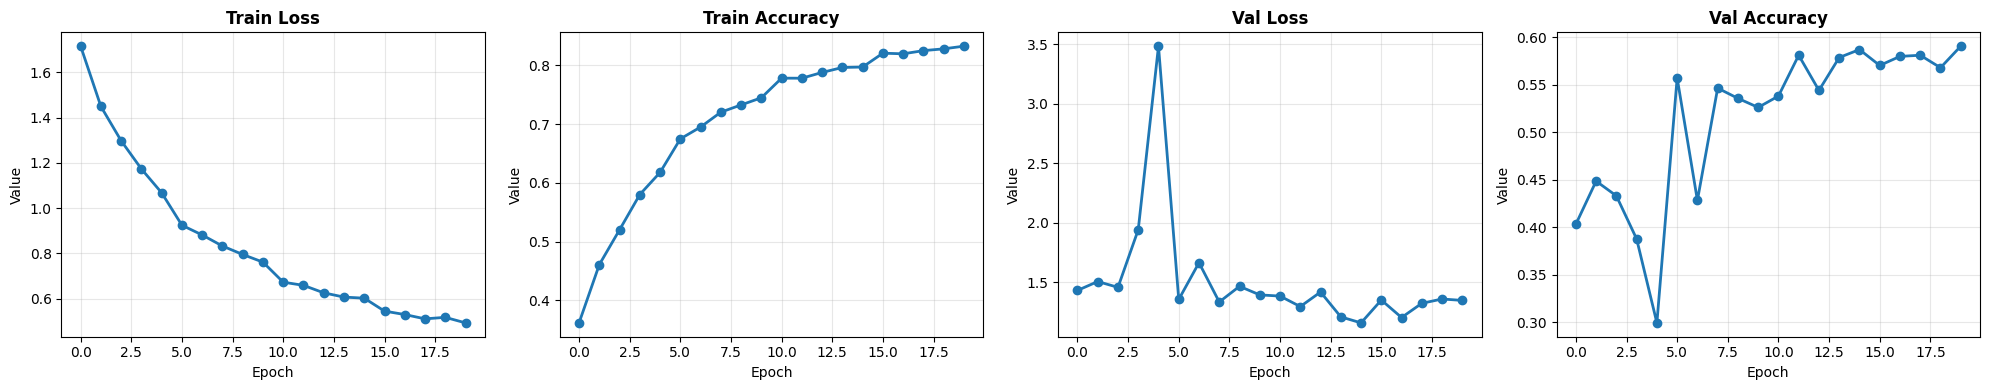

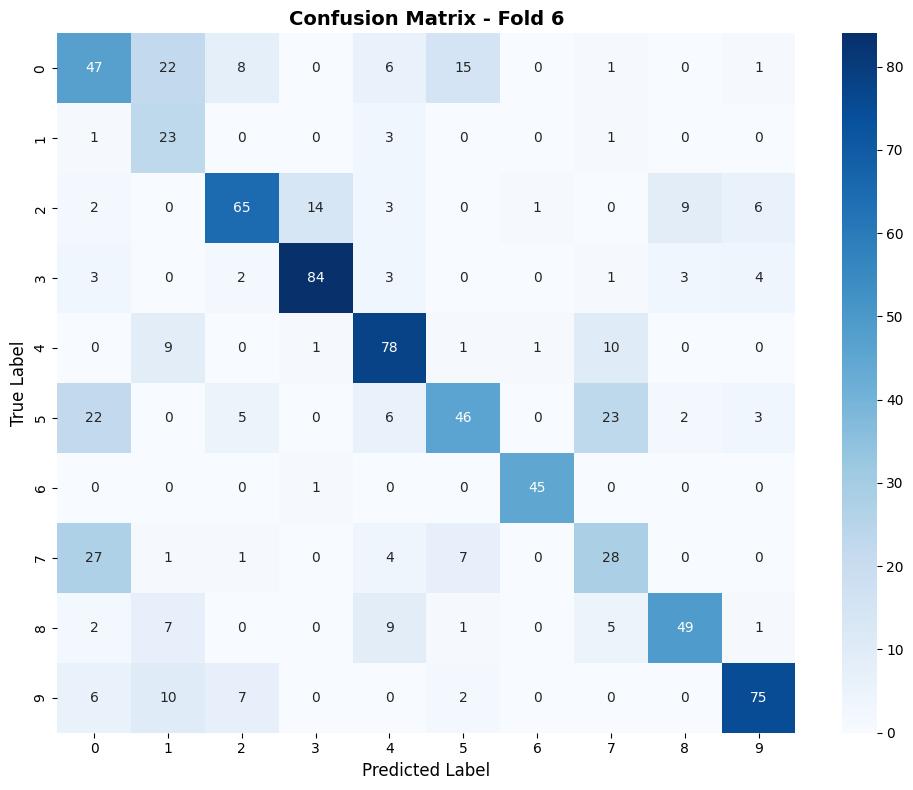


Fold 6 completed!
Results saved to: ../saved_cv/1130_014235/fold_6

FOLD 7/10
Test fold: 7
Validation fold: 8
Training folds: [1, 2, 3, 4, 5, 6, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 29,706
GPU memory after model creation: 18.26 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.7463, Train Acc: 0.3474
Val Loss: 2.1483, Val Acc: 0.2655
✓ Best model saved (Val Loss: 2.1483)

Epoch 2/20
----------------------------------------


Train Loss: 1.4783, Train Acc: 0.4507
Val Loss: 3.5155, Val Acc: 0.2072

Epoch 3/20
----------------------------------------


Train Loss: 1.3293, Train Acc: 0.5100
Val Loss: 2.0359, Val Acc: 0.2940
✓ Best model saved (Val Loss: 2.0359)

Epoch 4/20
----------------------------------------


Train Loss: 1.2198, Train Acc: 0.5605
Val Loss: 2.9796, Val Acc: 0.2308

Epoch 5/20
----------------------------------------


Train Loss: 1.1622, Train Acc: 0.5824
Val Loss: 1.7154, Val Acc: 0.4342
✓ Best model saved (Val Loss: 1.7154)

Epoch 6/20
----------------------------------------


Train Loss: 0.9972, Train Acc: 0.6476
Val Loss: 1.5203, Val Acc: 0.5658
✓ Best model saved (Val Loss: 1.5203)

Epoch 7/20
----------------------------------------


Train Loss: 0.9464, Train Acc: 0.6738
Val Loss: 1.4310, Val Acc: 0.5372
✓ Best model saved (Val Loss: 1.4310)

Epoch 8/20
----------------------------------------


Train Loss: 0.8804, Train Acc: 0.6991
Val Loss: 3.2110, Val Acc: 0.3486

Epoch 9/20
----------------------------------------


Train Loss: 0.8603, Train Acc: 0.7049
Val Loss: 2.6060, Val Acc: 0.4690

Epoch 10/20
----------------------------------------


Train Loss: 0.8275, Train Acc: 0.7128
Val Loss: 1.4831, Val Acc: 0.5484

Epoch 11/20
----------------------------------------


Train Loss: 0.7340, Train Acc: 0.7496
Val Loss: 1.4725, Val Acc: 0.6476

Epoch 12/20
----------------------------------------


Train Loss: 0.7098, Train Acc: 0.7567
Val Loss: 1.4312, Val Acc: 0.6179

Epoch 13/20
----------------------------------------


Train Loss: 0.6800, Train Acc: 0.7699
Val Loss: 1.5281, Val Acc: 0.5980

Epoch 14/20
----------------------------------------


Train Loss: 0.6672, Train Acc: 0.7725
Val Loss: 1.7253, Val Acc: 0.6117

Epoch 15/20
----------------------------------------


Train Loss: 0.6450, Train Acc: 0.7804
Val Loss: 1.2998, Val Acc: 0.6427
✓ Best model saved (Val Loss: 1.2998)

Epoch 16/20
----------------------------------------


Train Loss: 0.5960, Train Acc: 0.7983
Val Loss: 1.5282, Val Acc: 0.6501

Epoch 17/20
----------------------------------------


Train Loss: 0.5820, Train Acc: 0.8072
Val Loss: 1.4774, Val Acc: 0.6191

Epoch 18/20
----------------------------------------


Train Loss: 0.5744, Train Acc: 0.8039
Val Loss: 1.4475, Val Acc: 0.6092

Epoch 19/20
----------------------------------------


Train Loss: 0.5541, Train Acc: 0.8108
Val Loss: 1.5184, Val Acc: 0.6129

Epoch 20/20
----------------------------------------


Train Loss: 0.5587, Train Acc: 0.8097
Val Loss: 1.7498, Val Acc: 0.5931

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 27/27 [00:00<00:00, 59.13it/s, loss=0.9146]



Test Loss: 1.6572
Test Accuracy: 0.5167

Test Metrics:
  Accuracy:          0.5167
  Precision (macro): 0.6342
  Recall (macro):    0.5368
  F1-Score (macro):  0.5634
  Precision (wtd):   0.6010
  Recall (wtd):      0.5167
  F1-Score (wtd):    0.5374


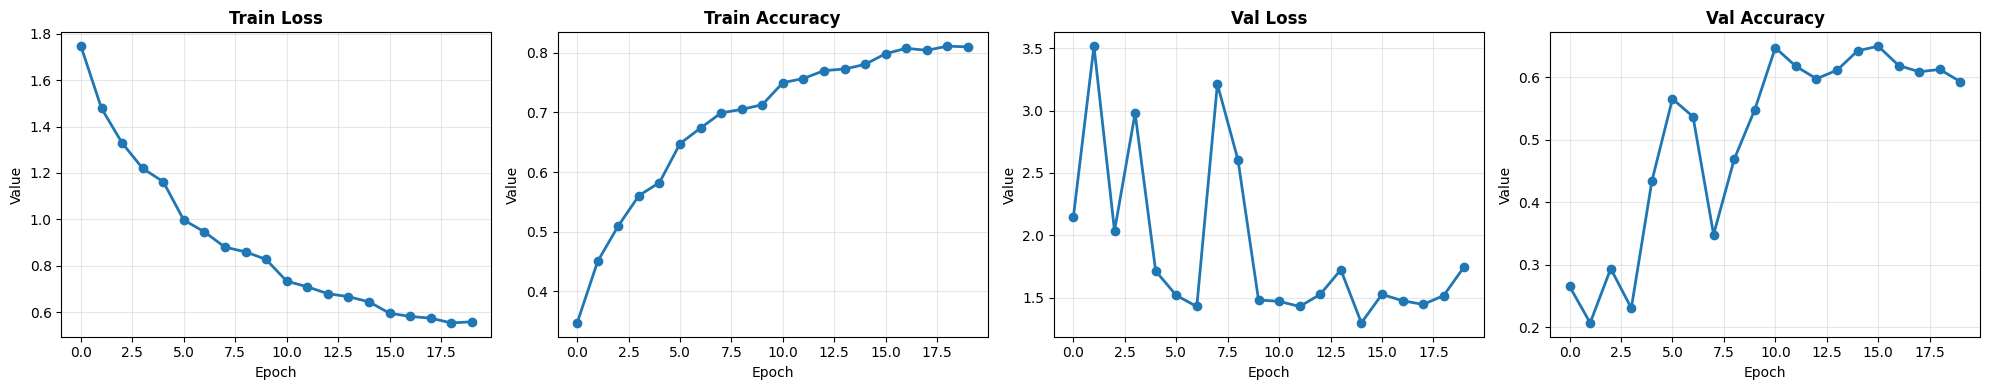

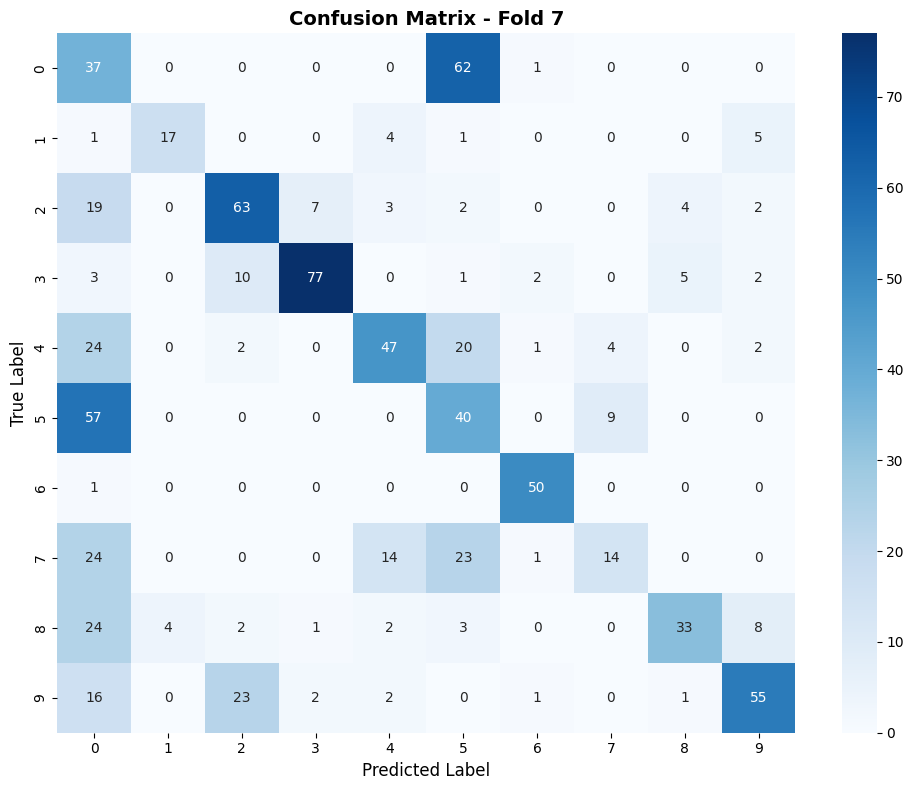


Fold 7 completed!
Results saved to: ../saved_cv/1130_014235/fold_7

FOLD 8/10
Test fold: 8
Validation fold: 9
Training folds: [1, 2, 3, 4, 5, 6, 7, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 29,706
GPU memory after model creation: 18.26 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.7140, Train Acc: 0.3579
Val Loss: 1.7676, Val Acc: 0.4387
✓ Best model saved (Val Loss: 1.7676)

Epoch 2/20
----------------------------------------


Train Loss: 1.4349, Train Acc: 0.4568
Val Loss: 1.6001, Val Acc: 0.4718
✓ Best model saved (Val Loss: 1.6001)

Epoch 3/20
----------------------------------------


Train Loss: 1.3107, Train Acc: 0.5136
Val Loss: 1.6366, Val Acc: 0.4167

Epoch 4/20
----------------------------------------


Train Loss: 1.2182, Train Acc: 0.5608
Val Loss: 1.3316, Val Acc: 0.5588
✓ Best model saved (Val Loss: 1.3316)

Epoch 5/20
----------------------------------------


Train Loss: 1.1456, Train Acc: 0.5971
Val Loss: 3.4652, Val Acc: 0.2598

Epoch 6/20
----------------------------------------


Train Loss: 0.9692, Train Acc: 0.6615
Val Loss: 1.2972, Val Acc: 0.6703
✓ Best model saved (Val Loss: 1.2972)

Epoch 7/20
----------------------------------------


Train Loss: 0.9339, Train Acc: 0.6805
Val Loss: 2.3903, Val Acc: 0.4424

Epoch 8/20
----------------------------------------


Train Loss: 0.8790, Train Acc: 0.7033
Val Loss: 1.5904, Val Acc: 0.6103

Epoch 9/20
----------------------------------------


Train Loss: 0.8480, Train Acc: 0.7147
Val Loss: 1.4359, Val Acc: 0.6924

Epoch 10/20
----------------------------------------


Train Loss: 0.8140, Train Acc: 0.7267
Val Loss: 1.3454, Val Acc: 0.6176

Epoch 11/20
----------------------------------------


Train Loss: 0.7303, Train Acc: 0.7588
Val Loss: 1.9363, Val Acc: 0.6250

Epoch 12/20
----------------------------------------


Train Loss: 0.7032, Train Acc: 0.7658
Val Loss: 1.2319, Val Acc: 0.6961
✓ Best model saved (Val Loss: 1.2319)

Epoch 13/20
----------------------------------------


Train Loss: 0.6657, Train Acc: 0.7797
Val Loss: 1.4995, Val Acc: 0.6703

Epoch 14/20
----------------------------------------


Train Loss: 0.6565, Train Acc: 0.7807
Val Loss: 1.7534, Val Acc: 0.6324

Epoch 15/20
----------------------------------------


Train Loss: 0.6385, Train Acc: 0.7850
Val Loss: 1.7582, Val Acc: 0.6532

Epoch 16/20
----------------------------------------


Train Loss: 0.5874, Train Acc: 0.8036
Val Loss: 1.5249, Val Acc: 0.6949

Epoch 17/20
----------------------------------------


Train Loss: 0.5807, Train Acc: 0.8071
Val Loss: 1.3027, Val Acc: 0.7096

Epoch 18/20
----------------------------------------


Train Loss: 0.5526, Train Acc: 0.8131
Val Loss: 1.3408, Val Acc: 0.7206

Epoch 19/20
----------------------------------------


Train Loss: 0.5475, Train Acc: 0.8167
Val Loss: 1.4618, Val Acc: 0.6691

Epoch 20/20
----------------------------------------


Train Loss: 0.5331, Train Acc: 0.8201
Val Loss: 1.4597, Val Acc: 0.6801

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 26/26 [00:00<00:00, 57.52it/s, loss=1.1677]



Test Loss: 1.2076
Test Accuracy: 0.6811

Test Metrics:
  Accuracy:          0.6811
  Precision (macro): 0.7580
  Recall (macro):    0.7090
  F1-Score (macro):  0.7056
  Precision (wtd):   0.7248
  Recall (wtd):      0.6811
  F1-Score (wtd):    0.6712


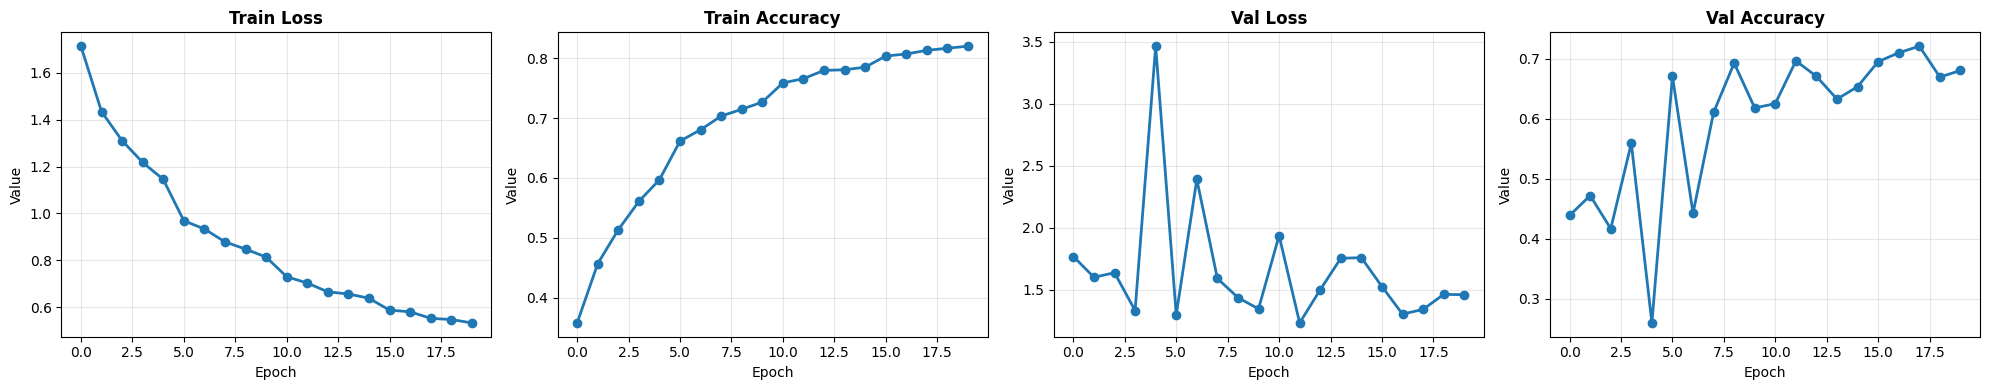

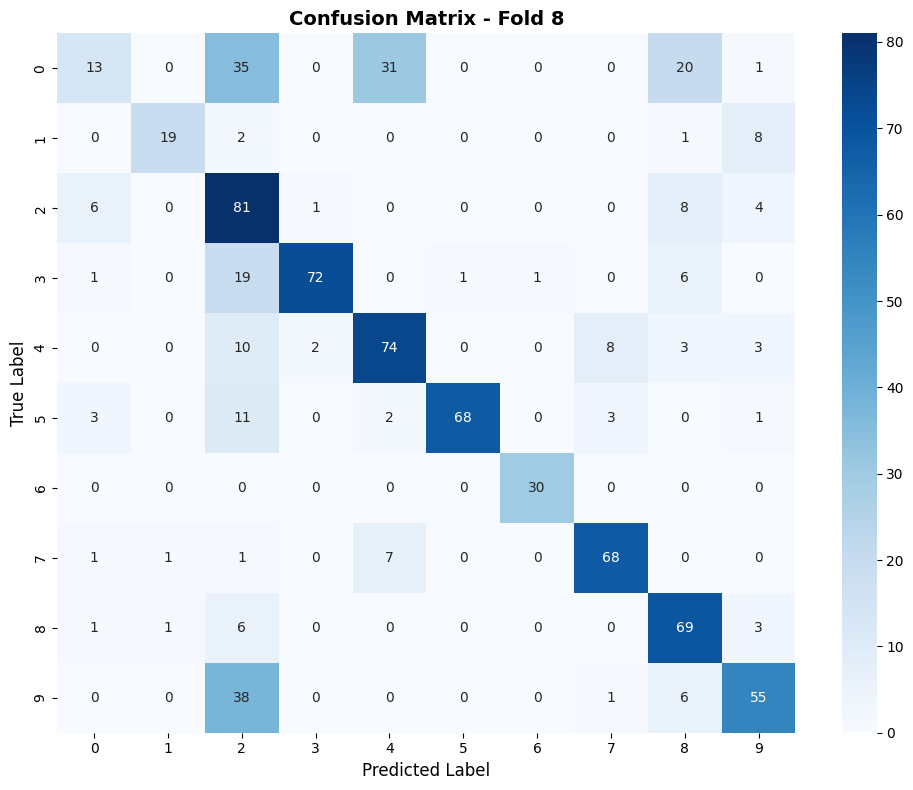


Fold 8 completed!
Results saved to: ../saved_cv/1130_014235/fold_8

FOLD 9/10
Test fold: 9
Validation fold: 10
Training folds: [1, 2, 3, 4, 5, 6, 7, 8]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 29,706
GPU memory after model creation: 18.26 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.7345, Train Acc: 0.3506
Val Loss: 1.6337, Val Acc: 0.4217
✓ Best model saved (Val Loss: 1.6337)

Epoch 2/20
----------------------------------------


Train Loss: 1.4823, Train Acc: 0.4481
Val Loss: 1.3035, Val Acc: 0.5341
✓ Best model saved (Val Loss: 1.3035)

Epoch 3/20
----------------------------------------


Train Loss: 1.3303, Train Acc: 0.5132
Val Loss: 1.3940, Val Acc: 0.4444

Epoch 4/20
----------------------------------------


Train Loss: 1.2278, Train Acc: 0.5615
Val Loss: 1.8574, Val Acc: 0.3692

Epoch 5/20
----------------------------------------


Train Loss: 1.1345, Train Acc: 0.6003
Val Loss: 1.9618, Val Acc: 0.3823

Epoch 6/20
----------------------------------------


Train Loss: 0.9560, Train Acc: 0.6675
Val Loss: 1.1095, Val Acc: 0.5866
✓ Best model saved (Val Loss: 1.1095)

Epoch 7/20
----------------------------------------


Train Loss: 0.8825, Train Acc: 0.7008
Val Loss: 1.0839, Val Acc: 0.5771
✓ Best model saved (Val Loss: 1.0839)

Epoch 8/20
----------------------------------------


Train Loss: 0.8719, Train Acc: 0.7090
Val Loss: 1.3310, Val Acc: 0.5400

Epoch 9/20
----------------------------------------


Train Loss: 0.8055, Train Acc: 0.7335
Val Loss: 0.9395, Val Acc: 0.6619
✓ Best model saved (Val Loss: 0.9395)

Epoch 10/20
----------------------------------------


Train Loss: 0.7835, Train Acc: 0.7431
Val Loss: 2.0090, Val Acc: 0.4325

Epoch 11/20
----------------------------------------


Train Loss: 0.6811, Train Acc: 0.7778
Val Loss: 1.3405, Val Acc: 0.5615

Epoch 12/20
----------------------------------------


Train Loss: 0.6483, Train Acc: 0.7904
Val Loss: 1.7740, Val Acc: 0.4683

Epoch 13/20
----------------------------------------


Train Loss: 0.6364, Train Acc: 0.7950
Val Loss: 0.7907, Val Acc: 0.7228
✓ Best model saved (Val Loss: 0.7907)

Epoch 14/20
----------------------------------------


Train Loss: 0.6097, Train Acc: 0.8049
Val Loss: 0.7566, Val Acc: 0.7455
✓ Best model saved (Val Loss: 0.7566)

Epoch 15/20
----------------------------------------


Train Loss: 0.5875, Train Acc: 0.8133
Val Loss: 0.7228, Val Acc: 0.7503
✓ Best model saved (Val Loss: 0.7228)

Epoch 16/20
----------------------------------------


Train Loss: 0.5424, Train Acc: 0.8244
Val Loss: 0.8368, Val Acc: 0.7180

Epoch 17/20
----------------------------------------


Train Loss: 0.5306, Train Acc: 0.8258
Val Loss: 0.7778, Val Acc: 0.7384

Epoch 18/20
----------------------------------------


Train Loss: 0.5205, Train Acc: 0.8304
Val Loss: 0.7718, Val Acc: 0.7348

Epoch 19/20
----------------------------------------


Train Loss: 0.5102, Train Acc: 0.8372
Val Loss: 0.7501, Val Acc: 0.7503

Epoch 20/20
----------------------------------------


Train Loss: 0.4834, Train Acc: 0.8435
Val Loss: 0.8486, Val Acc: 0.7013

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 26/26 [00:00<00:00, 57.99it/s, loss=2.7210]



Test Loss: 1.2137
Test Accuracy: 0.7096

Test Metrics:
  Accuracy:          0.7096
  Precision (macro): 0.7244
  Recall (macro):    0.7498
  F1-Score (macro):  0.7064
  Precision (wtd):   0.7196
  Recall (wtd):      0.7096
  F1-Score (wtd):    0.6833


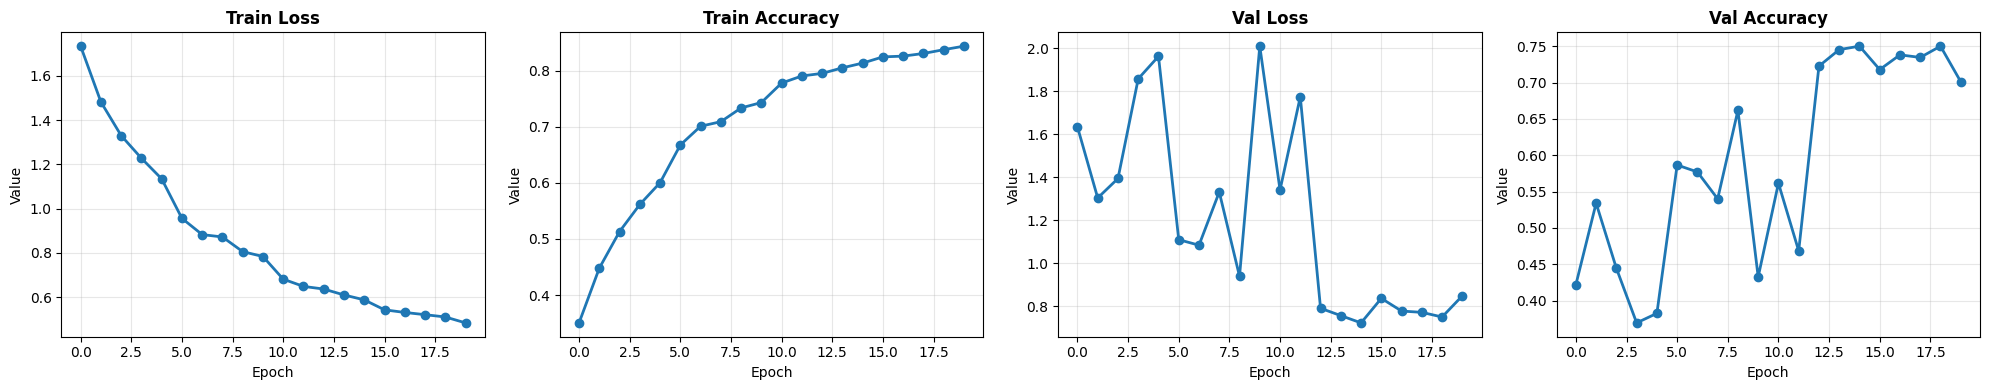

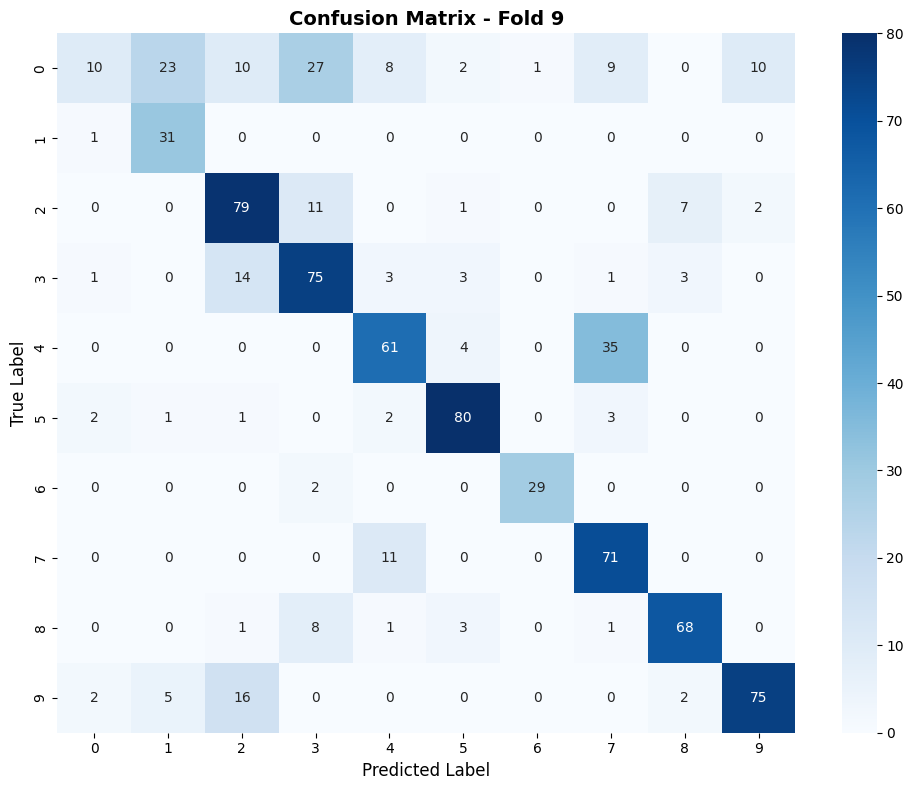


Fold 9 completed!
Results saved to: ../saved_cv/1130_014235/fold_9

FOLD 10/10
Test fold: 10
Validation fold: 1
Training folds: [2, 3, 4, 5, 6, 7, 8, 9]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 29,706
GPU memory after model creation: 18.26 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.7230, Train Acc: 0.3591
Val Loss: 1.7892, Val Acc: 0.3127
✓ Best model saved (Val Loss: 1.7892)

Epoch 2/20
----------------------------------------


Train Loss: 1.4489, Train Acc: 0.4640
Val Loss: 1.9637, Val Acc: 0.3723

Epoch 3/20
----------------------------------------


Train Loss: 1.3000, Train Acc: 0.5223
Val Loss: 1.5751, Val Acc: 0.4570
✓ Best model saved (Val Loss: 1.5751)

Epoch 4/20
----------------------------------------


Train Loss: 1.2078, Train Acc: 0.5657
Val Loss: 2.7924, Val Acc: 0.3047

Epoch 5/20
----------------------------------------


Train Loss: 1.1469, Train Acc: 0.5970
Val Loss: 2.0099, Val Acc: 0.3562

Epoch 6/20
----------------------------------------


Train Loss: 0.9638, Train Acc: 0.6677
Val Loss: 1.8083, Val Acc: 0.5796

Epoch 7/20
----------------------------------------


Train Loss: 0.9069, Train Acc: 0.6949
Val Loss: 1.8366, Val Acc: 0.4490

Epoch 8/20
----------------------------------------


Train Loss: 0.8580, Train Acc: 0.7076
Val Loss: 1.2502, Val Acc: 0.6472
✓ Best model saved (Val Loss: 1.2502)

Epoch 9/20
----------------------------------------


Train Loss: 0.8106, Train Acc: 0.7330
Val Loss: 1.6428, Val Acc: 0.4467

Epoch 10/20
----------------------------------------


Train Loss: 0.7658, Train Acc: 0.7413
Val Loss: 1.7027, Val Acc: 0.5304

Epoch 11/20
----------------------------------------


Train Loss: 0.6672, Train Acc: 0.7831
Val Loss: 1.2926, Val Acc: 0.6048

Epoch 12/20
----------------------------------------


Train Loss: 0.6480, Train Acc: 0.7864
Val Loss: 1.3441, Val Acc: 0.6174

Epoch 13/20
----------------------------------------


Train Loss: 0.6181, Train Acc: 0.7978
Val Loss: 1.5989, Val Acc: 0.5796

Epoch 14/20
----------------------------------------


Train Loss: 0.6109, Train Acc: 0.8032
Val Loss: 1.4642, Val Acc: 0.5819

Epoch 15/20
----------------------------------------


Train Loss: 0.5734, Train Acc: 0.8126
Val Loss: 1.8804, Val Acc: 0.5017

Epoch 16/20
----------------------------------------


Train Loss: 0.5323, Train Acc: 0.8239
Val Loss: 1.3141, Val Acc: 0.6632

Epoch 17/20
----------------------------------------


Train Loss: 0.5106, Train Acc: 0.8328
Val Loss: 1.5797, Val Acc: 0.5968

Epoch 18/20
----------------------------------------


Train Loss: 0.5065, Train Acc: 0.8334
Val Loss: 1.4522, Val Acc: 0.5796

Epoch 19/20
----------------------------------------


Train Loss: 0.4938, Train Acc: 0.8373
Val Loss: 1.5174, Val Acc: 0.6060

Epoch 20/20
----------------------------------------


Train Loss: 0.4759, Train Acc: 0.8400
Val Loss: 1.4728, Val Acc: 0.6392

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 27/27 [00:00<00:00, 50.22it/s, loss=0.2288]



Test Loss: 0.9443
Test Accuracy: 0.6607

Test Metrics:
  Accuracy:          0.6607
  Precision (macro): 0.7030
  Recall (macro):    0.6964
  F1-Score (macro):  0.6656
  Precision (wtd):   0.7084
  Recall (wtd):      0.6607
  F1-Score (wtd):    0.6532


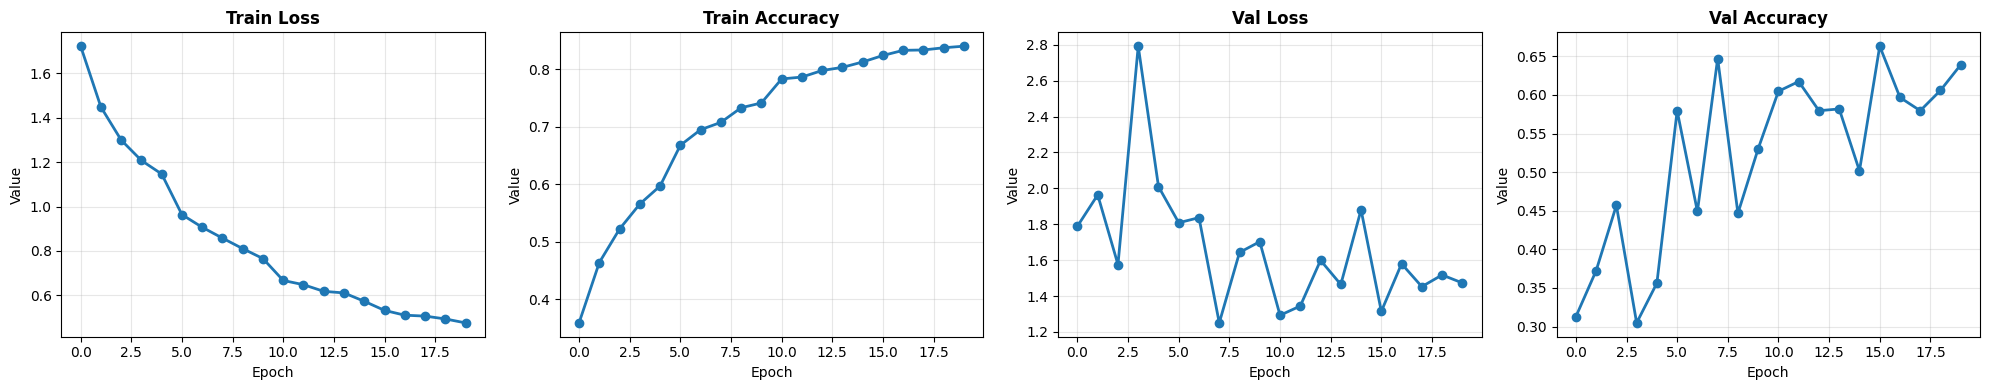

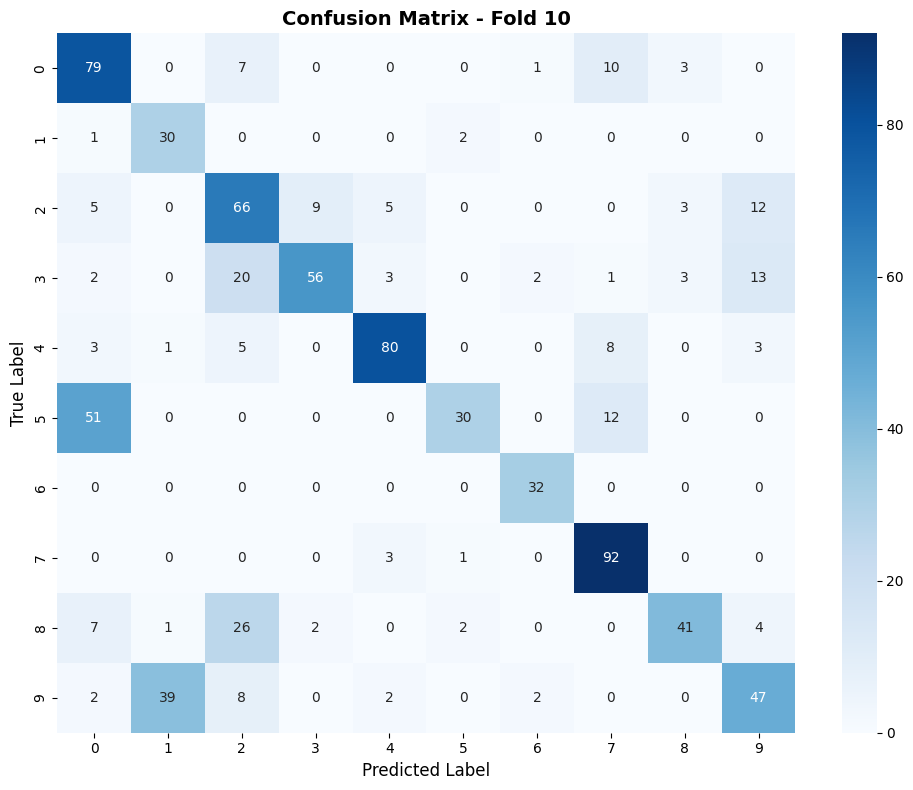


Fold 10 completed!
Results saved to: ../saved_cv/1130_014235/fold_10

CROSS-VALIDATION RESULTS

CROSS-VALIDATION RESULTS

Metrics per fold:
Fold   Acc      Prec(M)    Rec(M)     F1(M)     
--------------------------------------------------
1      0.6460   0.6345     0.6743     0.6398    
2      0.6520   0.7162     0.6766     0.6797    
3      0.5535   0.5971     0.6066     0.5863    
4      0.6758   0.6929     0.6743     0.6791    
5      0.7682   0.7905     0.7784     0.7773    
6      0.6561   0.6635     0.6794     0.6570    
7      0.5167   0.6342     0.5368     0.5634    
8      0.6811   0.7580     0.7090     0.7056    
9      0.7096   0.7244     0.7498     0.7064    
10     0.6607   0.7030     0.6964     0.6656    

AGGREGATE RESULTS (Mean ± Std)
Accuracy:              0.6520 ± 0.0681
Precision (macro):     0.6914 ± 0.0568
Recall (macro):        0.6782 ± 0.0645
F1-Score (macro):      0.6660 ± 0.0580
Precision (weighted):  0.6832 ± 0.0539
Recall (weighted):     0.6520 ± 0.0681
F1-

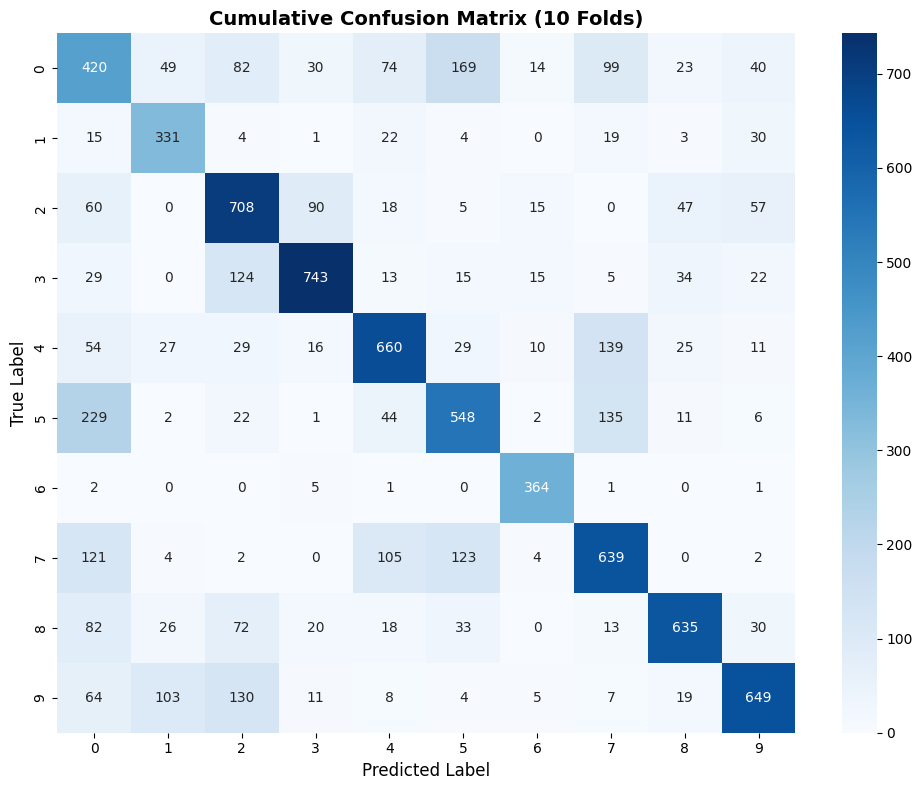

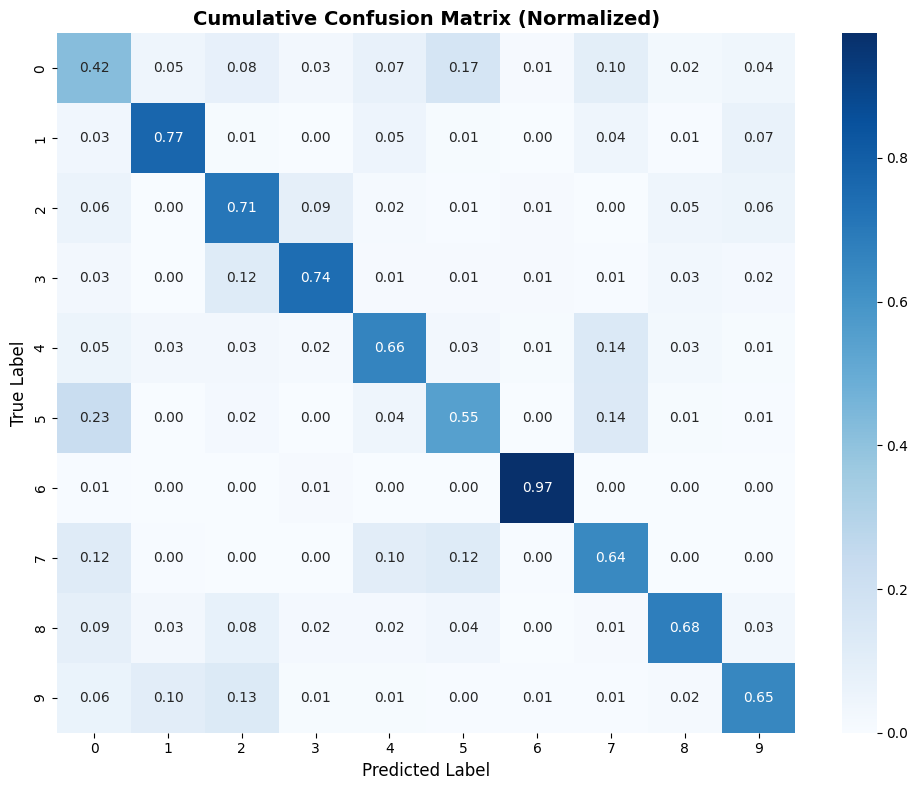

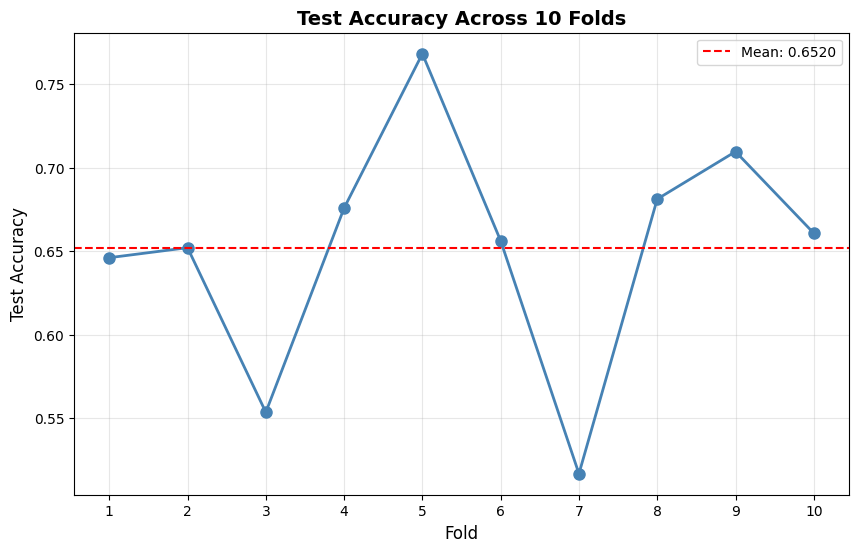

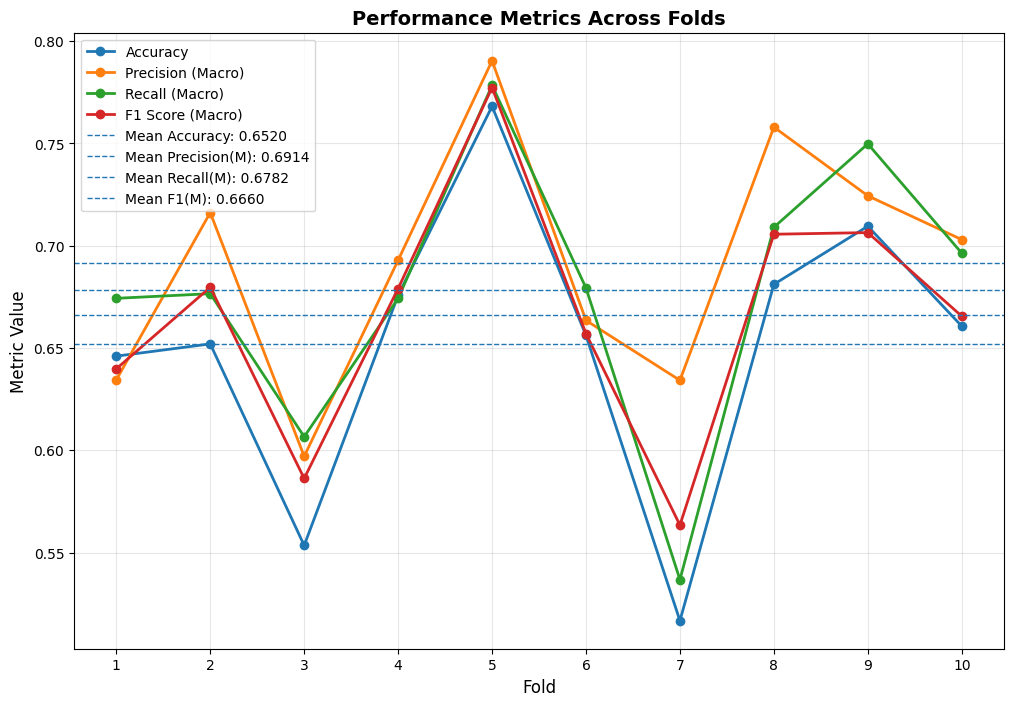


All results saved to: ../saved_cv/1130_014235
Model saved to: ../saved_cv/1130_014235


In [6]:
results = train_audio_cnn_cross_validation(data_cache_dir, config)
print(f"Model saved to: {results['save_dir']}")